In [1]:
# Import required packages
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from shapely import geometry
from xcube_sh.sentinelhub import SentinelHub
import xarray as xr
import json
import IPython.display
import shapely.geometry

from sentinelhub import BBox, WmsRequest, DataSource, SHConfig
from functools import partial

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
# Set Sentinel Hub credentials
import os
sh_credentials = dict(client_id=os.environ['SH_CLIENT_ID'],
                      client_secret=os.environ['SH_CLIENT_SECRET']) # This is only provided when the Oauth credentials are created

# Sentinel-3 OLCI, Sentinel-3 SLSTR and Sentinel-5 layers are processed on different infrastructure, 
# which requires to used different end-point

sh_credentials.update(api_url='https://creodias.sentinel-hub.com')

In [3]:
f=open('../xcube/countries.json')
data=json.load(f)
final=dict()
for i in range(0,len(data['features'])):
    #print(data['features'][i]['id'])
    final[data['features'][i]['id']]=data['features'][i]['geometry']['coordinates']

In [4]:
EU_countries={'AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC',
'HUN','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU','SVK','SVN','ESP',
'SWE','ALB','ARM','BLR','BIH','GEO','ISL',
'MKD','MDA','MCO','MNE','NOR','RUS','SRB','CHE','TUR','UKR','GBR'}

In [23]:
aoi = dict()
for country in EU_countries:
    if len(final[country])!=1:
        xs=0
        ys=0
        all_x=[]
        all_y=[]
        for i in range(0,len(final[country])):
            state=geometry.Polygon(final[country][i][0])
            geom = np.array(state.exterior.coords.xy)
            xs = geom[0]
            ys = geom[1]
            all_x.extend(xs)
            all_y.extend(ys)
    else:
        state=geometry.Polygon(final[country][0])
        geom = np.array(state.exterior.coords.xy)
        all_x = geom[0]
        all_y = geom[1]
    aoi[country]=(min(all_x),
                    min(all_y),
                    max(all_x),
                    max(all_y))

In [24]:
def caculate(geometry, timerange):
    
    cube_config = CubeConfig(dataset_name='S5PL2',
                         band_names=['NO2'],
                         tile_size=[512, 512],
                         bbox=geometry,
                         spatial_res=abs(geometry[2]-geometry[0])/512, # spatial resolution (approx. 20 m in degree)
                         time_range= timerange,
                         time_period='7D') 
    cube = open_cube(cube_config, **sh_credentials)

    return cube.mean(dim=["lon","lat"],skipna=True).to_dataframe()


In [ ]:
import time 

start = time.time()
aoi_S5PL2 = list()

# Check length of provided aoi list OR dataframe
len_aoi = len(aoi)

# Define how many AOIs you want to process. For the demo we will use only one 
counter = 42

for i in aoi.keys():
    aoi_dict = dict()
    print("Processing: ", i)      
    timerange = ['2018-01-01', '2020-12-01']
    aoi_dict[str(i)] = caculate(aoi[str(i)], timerange)
    shape = aoi_dict[str(i)].shape
    nullCount = sum(aoi_dict[str(i)].isna().sum())
    print(f"Shape of 2018 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))

    aoi_S5PL2.append(aoi_dict)

end = time.time()

Processing:  BLR


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Shape of 2018 DF: (306, 2), Count of Null values: 38
Processing:  LUX


In [ ]:
import pickle 
print(len(aoi_S5PL2))
with open('aoi_list_S5PL2.pkl', 'wb') as f:
    pickle.dump(aoi_S5PL2, f)

In [86]:
# Test #

In [11]:
cube_config = CubeConfig(dataset_name='S5PL2',
                         band_names=['O3','NO2','SO2','CO','CH4'],
                         tile_size=[512, 512],
                         bbox=aoi["ITA"],
                         spatial_res=(aoi["ITA"][2]-aoi["ITA"][0])/512, # spatial resolution (approx. 20 m in degree)
                         time_range= ['2018-01-01', '2018-12-01'],
                         time_period='7D') 
cube = open_cube(cube_config, **sh_credentials)


In [40]:
from xcube.core.resample import resample_in_time

In [50]:
resample_in_time(cube,"7D","mean")

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xarray/core/common.py:1131: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


<xarray.Dataset>
Dimensions:   ()
Data variables:
    CH4_mean  float32 dask.array<chunksize=(), meta=np.ndarray>
    CO_mean   float32 dask.array<chunksize=(), meta=np.ndarray>
    NO2_mean  float32 dask.array<chunksize=(), meta=np.ndarray>
    O3_mean   float32 dask.array<chunksize=(), meta=np.ndarray>
    SO2_mean  float32 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S5PL2 Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-06-26T07:56:25.846772
    time_coverage_start:       <xarray.DataArray 'time' ()>\narray('2018-01-0...
    time_coverage_end:         <xarray.DataArray 'time' ()>\narray('2018-11-2...
    time_coverage_duration:    P336DT0H0M0S
    time_coverage_resolution:  P7DT0H0M0S
    geospatial_lon_min:        6.749955
    geospatial_lat_min:        36.619987
    geospatial_lon_max:        18.480247
    geospatial_lat_max:        47.113099765625

In [15]:
cube.NO2.mean(dim=["lon","lat"],skipna=True).to_dataframe()

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,NO2
time,
2018-01-04 12:00:00,NaN
2018-01-11 12:00:00,NaN
2018-01-18 12:00:00,NaN
2018-01-25 12:00:00,NaN
2018-02-01 12:00:00,NaN
2018-02-08 12:00:00,NaN
2018-02-15 12:00:00,NaN
2018-02-22 12:00:00,NaN
2018-03-01 12:00:00,NaN


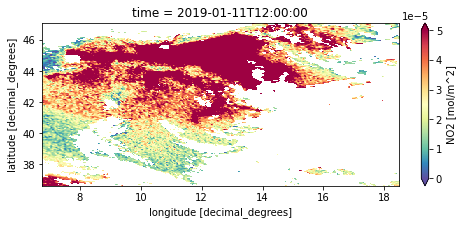

In [30]:
cube.NO2.isel(time=1).plot.imshow(vmin=0, vmax= 0.00005, cmap='Spectral_r', figsize=(8,3))

In [24]:
IPython.display.GeoJSON(shapely.geometry.box(*aoi["ITA"]).__geo_interface__)

<IPython.display.GeoJSON object>

In [11]:
cube_config = CubeConfig(dataset_name='S5PL2',
                         band_names=['NO2'],
                         tile_size=[512, 512],
                         bbox=aoi["ITA"],
                         spatial_res=abs(aoi["ITA"][2]-aoi["ITA"][0])/512,
                         time_range=['2020-01-22', '2020-02-11'],
                         time_period='7D')

In [12]:
cube = open_cube(cube_config, **sh_credentials)
p=cube.NO2.isel(time=1).values[:]

In [137]:
print(np.shape(p))

(1024, 1024)


In [153]:
nan_array = np.isnan(p)
not_nan_array = ~ nan_array
p = p[not_nan_array]
np.mean(p)

2.6783564e-05

In [13]:
np.nanmean(cube.NO2.isel(time=1).values[:])

2.8876319e-05

In [26]:
%matplotlib inline

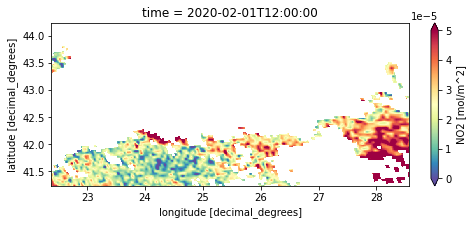

In [145]:
cube.NO2.isel(time=1).plot.imshow(vmin=0, vmax= 0.00005, cmap='Spectral_r', figsize=(8,3))